# Projet M1 

Réalisé par :
* Jean Le Bellego
* Simon Lecoq

#### Initialisation et dépendances 
Etape intermédiaire consistant à importer les bibliothèques.

**Nota Bene** : Il est possible de masquer certaines portions de code pour rendre le document plus clair.

In [1]:
#!masquer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io.wavfile as sw
import math
from scipy import signal
from scipy.signal import butter, lfilter
from operator import add

In [2]:
%%html
<script>
//!masquer
IPython.OutputArea.prototype._should_scroll = lines => { return false }
function show_code() { $('div.input').show() }   
function hide_code() { $("div.input").each((i, input) => /!masquer/i.test($(input).text()) ? $(input).hide() : $(input).show()) }                 
</script>
<form action="javascript:show_code()" style="float:left"><input type="submit" style="width:200px;padding:4px;border-radius:5px;margin:10px" value="Forcer l'affichage du code"></form>
<form action="javascript:hide_code()" style="float:left"><input type="submit" style="width:200px;padding:4px;border-radius:5px;margin:10px" value="Masquer les codes"></form>

# Fichier audio

La source du fichier audio qui sera utilisée par le reste du programme peut être configurée dans la cellule ci-dessous.

In [3]:
# Source
file = "src/test2.wav"

Ci-dessous sont définit certaines variables globales :
* **y** : Signal d'entrée
* **fs** : Fréquence d'échantillonage de ce signal
* **N** : Nombre de points échantillonés
* **t** : Points temporels

In [4]:
# Lecture du fichier audio
fs, y = sw.read(file)
# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

#### Spectre d'amplitude

Il représente l'amplitude relative des impulsions sonores (en ordonnée) selon le temps (en abscisse).

In [5]:
#! masquer
# Affichage du spectre d'amplitude
# - y : Amplitudes
# - t : Echelle temporelle
def plot_specamp(y, t):
    plt.figure(figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
    plt.title("Piste audio")
    plt.xlabel("Temps [s]")
    plt.ylabel("Amplitude [Ø]")
    plt.xlim(0, t[-1])
    plt.ylim(-1, +1)
    plt.plot(t, y)
    plt.show()

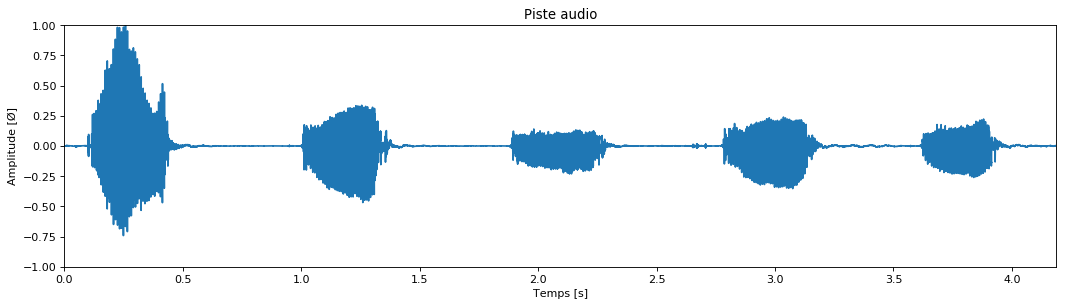

In [6]:
#!masquer
plot_specamp(y/max(abs(y)), t)

#### Spectrogramme

Il représente la densité spectrale de puissance (par nuances de couleurs) par fréquence (en ordonnée) selon le temps (en abscisse). Les couleurs chaudes indiquent une forte énergie tandis que les couleurs froides en montrent l'absence.

In [7]:
#!masquer
# Affichage du spectrogramme
# - y : Amplitudes
# - t : Echelle temporelle
# - fs : Fréquence d'échantillonage
def plot_specgram(y, t, fs):
    plt.figure(figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
    plt.title("Spectrogramme")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [s]")
    plt.specgram(y, Fs=fs)
    plt.ylim(0, 20000)
    plt.xlim(0, t[-1])
    plt.show()

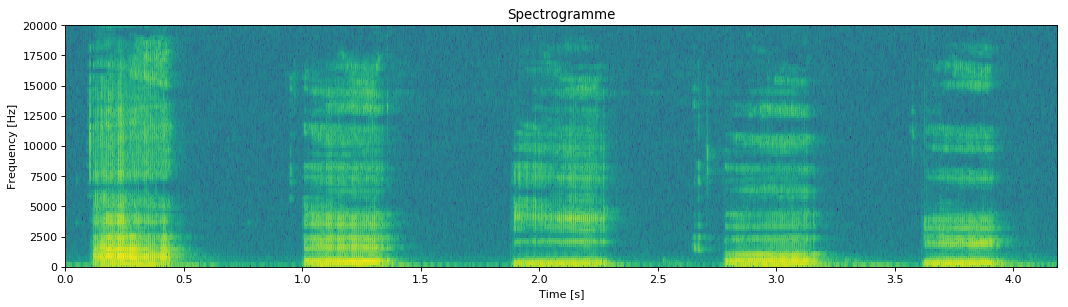

In [8]:
#!masquer
plot_specgram(y, t, fs)

# Banque de filtres

Ci-dessous peuvent être configurés les différents paramètres de la banque de filtres, tels que le nombre de filtres à utiliser et sa plage de fréquence, ainsi que l'ordre et le facteur de qualité de chaque filtre.

Il est aussi possible de configurer les spectrogrammes en modifiant la valeur de saturation de la densité spectrale de puissance ainsi que le seuil d'activité des filtres ainsi que la résolution temporelle.

In [9]:
# Nombre de filtres
nb_filters = 16
# Fréquence minimal
fmin = 300
# Fréquence maximal
fmax = 3000

# Ordre des filtres
n = 3
# Facteur de qualité
q = 3

# Valeur de saturation de la densité spectrale de puissance  
psd_max = 0.00000000001
# Résolution temporelle des spectrogramme (entre 0 et 1 exclu, sinon le pc va mourir))
time_res = 0.5

# Nombre de bits à utiliser pour pour stocker l'amplitude d'energie
amp_res = 4

#### Génération de la banque de filtres
Etape intermédiaire qui consiste à générer les différents filtres de la banque en fonction des paramètres ci-dessus.

In [10]:
#!masquer
# Génère un filtre passe-bande.
# - fc : Fréquence centrale
# - q : Facteur de qualité
# - n : Ordre du filtre
# - fs : Fréquence d'échantillonage
# Retourne :
# - filter : Filtre de Butterworth avec les caractéristiques indiquées
# - fc : Fréquence centrale
# - fl : Fréquence de coupure (basse)
# - fh : Fréquence de coupure (haute)
# - debug : Affiche les informations sur le filtre généré
def bandpass(fc, q, n, fs, debug=False):
    # Largeur de la bande passante
    df = fc / q
    # Fréquence de Nyquist
    nyq = fs / 2
    # Fréquences de coupures basses et hautes
    fl = (fc - df/2)
    fh = (fc + df/2)
    # Création du filtre
    if debug: print("Fc : {fc: >4}Hz  ({fl: >4}Hz - {fh: >4}Hz)".format(fc=round(fc), fl=round(fl), fh=round(fh)))  
    return butter(N=n, Wn=[fl/nyq, fh/nyq], btype="band"), fc, fl, fh

In [11]:
#!masquer
# Génère la banque des filtres
# - fmin : Fréquence minimum
# - fmax : Fréquence maximum
# - nb_filters : Nombre de filtres
# - q : Facteur de qualité
# - n : Ordre du filtre
# - fs : Fréquence d'échantillonage
# - step : Pas de génération des filtres
# - debug : Affiche les informations sur le filtre généré
# Retourne :
# filters : Liste des filtres générés
# filters_fq : Listes d'objets contenant "fc", "fl" et "fh" indiquant les fréquences caractéristiques du filtre associé
def gen_filters(fmin, fmax, nb_filters, q, n, fs, step, debug=False):
    # Initialisation
    filters = []; filters_fq = []

    # Génération des filtres
    for fc in range(fmin, fmax, step):
        bp, fc, fl, fh = bandpass(fc, q, n, fs, debug)
        filters.append(bp)
        filters_fq.append({"fc":fc, "fl":fl, "fh":fh})
    return filters, filters_fq

In [12]:
filters, filters_fq = gen_filters(fmin, fmax, nb_filters, q, n, fs, step=round((fmax-fmin)/nb_filters), debug=True)

Fc :  300Hz  ( 250Hz -  350Hz)
Fc :  469Hz  ( 391Hz -  547Hz)
Fc :  638Hz  ( 532Hz -  744Hz)
Fc :  807Hz  ( 672Hz -  942Hz)
Fc :  976Hz  ( 813Hz - 1139Hz)
Fc : 1145Hz  ( 954Hz - 1336Hz)
Fc : 1314Hz  (1095Hz - 1533Hz)
Fc : 1483Hz  (1236Hz - 1730Hz)
Fc : 1652Hz  (1377Hz - 1927Hz)
Fc : 1821Hz  (1518Hz - 2124Hz)
Fc : 1990Hz  (1658Hz - 2322Hz)
Fc : 2159Hz  (1799Hz - 2519Hz)
Fc : 2328Hz  (1940Hz - 2716Hz)
Fc : 2497Hz  (2081Hz - 2913Hz)
Fc : 2666Hz  (2222Hz - 3110Hz)
Fc : 2835Hz  (2362Hz - 3308Hz)


#### Réponse fréquentielle de la banque de filtres

Le passage ci-dessous affiche les réponses fréquentielle de chaque filtre de la banque sur la plage des sons audibles par l'oreille humaine.

In [13]:
#!masquer
# Affiche la réponse fréquentielle d'une liste de filtre
# - filters : Liste de filtres
def plot_freqz(filters):
    # Préparation de l'affichage
    plt.figure(figsize=(16, 10), dpi= 80, facecolor="w", edgecolor="k")

    # Affichage des filtres
    for i in range(len(filters)):
        # Calcul de la réponse fréquentielle du filtre
        b, a = filters[i]
        w, h = signal.freqz(b, a)
        # Affichage
        plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));

    # Données d'affichage
    plt.title("Réponse fréquentielle de la banque de filtre")
    plt.xlabel("Fréquence [Hz]")
    plt.ylabel("Gain [dB]")
    plt.xlim([0, 20000])
    plt.ylim([-200, 0])
    plt.grid(which="both", axis="both")
    plt.show()

C:\ProgramUser\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


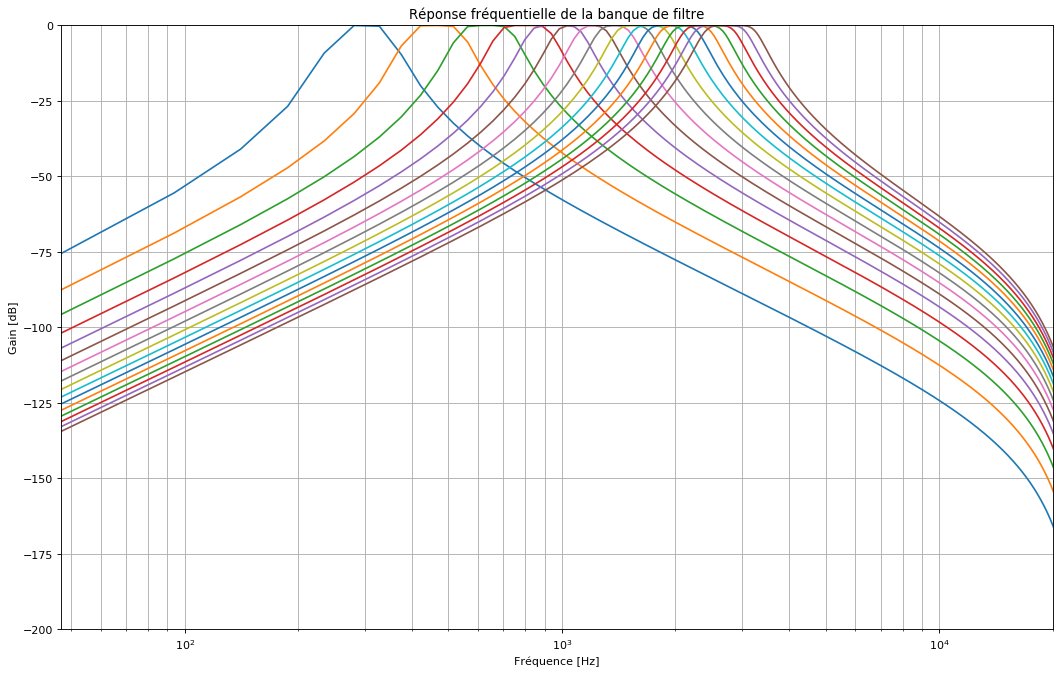

In [14]:
#! masquer
plot_freqz(filters)

#### Application de la banque de filtres

Une étape intermédiaire qui consiste à appliquer les différents filtres sur le signal d'entrée.

In [15]:
#!masquer
# Signaux filtrés
# - y : Amplitudes
# - fs : Fréquence d'échantillonage
# - filters : Liste de filtres
def gen_filtered(y, fs, filters):
    # Initialisation
    filtered = []; N = len(y);
    t = np.linspace(0, N/fs, N)
    # Application de la banque de filtres
    for i in range(len(filters)):
        # Calcul de la réponse
        b, a = filters[i]
        filtered.append(lfilter(b, a, y))
    return filtered

In [16]:
filtered = gen_filtered(y, fs, filters)

# Etude des signaux en sortie de la banque
Cette partie affiche le signal audio en sortie, le spectrogramme associé ainsi que les états après chaque application respective des filtres de la banque.

In [17]:
#!masquer
# Affiche les données du spectrogramme personnalisable
# - ax : Figure secondaire
# - y : Signal d'entrée
# - t : Echelle temporelle
# - rspectrum : Spectre généré par la fonction gen_data
# - rfreqs : Liste de fréquences généré par la fonction gen_data
# - rtime : Liste de points temporels généré par la fonction gen_data
# - step : Pas de génération des filtres
def plot_data(ax, y, t, rspectrum, rfreqs, rtime, step):
    # Affichage du spectre d'amplitude
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Amplitude [Ø]")
    ax[0].plot(t, y, color="aqua")
    ax[0].plot(t, y, color="darkblue")
    ax[0].set_xlim(0, t[-1])

    # Affichage du spectrogramme
    ax[1].cla()
    ax[1].set_ylabel("Frequency [Hz]")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_yticks(np.arange(rfreqs[0], rfreqs[-1], step))
    ax[1].pcolormesh(rtime, rfreqs, rspectrum)
    ax[1].set_xlim(0, t[-1])
    ax[1].plot()

    # Affichage
    plt.show()

In [18]:
#!masquer
# Affiche les données du spectrogramme personnalisable
# - filtered : Liste de signaux filtrés
# - fs : Fréquence d'échantillonage
# - time_res : Résolution temporelle
# - amp_res : Résolution en amplitude
# - psd_max : Amplitude maximum
# - nm : Permet de diviser le nombre de points à utiliser pour la FFT
# Retourne
# - ax : Figure secondaire
# - rspectrum : Spectre généré 
# - rfreqs : Liste de fréquences
# - rtime : Liste de points temporels
def gen_data(filtered, fs, time_res, amp_res, psd_max, nm = 2):
    # Figure et initialisation
    f, ax = plt.subplots(1, 2, figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
    rspectrum = [] ; rfreqs = []
    
    # NFFT 
        # Plus ce nombre est élevée, plus la résolution fréquentielle augemente
        # Cependant, le début et la fin seront "consommés" et aucune donnée ne pourra en être tirées
    NFFT = 2**int(math.log(fs, 2)-nm)

    # Traitement
    for i in range(len(filtered)):
        # Récupération du spectrogramme
        spectrum, freqs, rtime, img = ax[1].specgram(filtered[i], Fs=fs, NFFT=NFFT, noverlap=time_res*NFFT)
        
        # Regroupement de l'énergie par signal filtré 
        summed = spectrum[0]
        for k in range(1, len(freqs)): map(add, summed, spectrum[k])
            
        # Numérisation
            # Le signal pourra être compris entre 0 et une valeur de saturation
            # Ensuite, cette valeur est quantifiée selon la résolution configurée, par arrondi
        analog_data = np.clip(summed, 0, psd_max)
        numeric_data = np.round(np.array(analog_data)/(psd_max/(2**amp_res-1)))

        # Enregistrement
        rspectrum.append(numeric_data)
        rfreqs.append(filters_fq[i]["fc"])
    return ax, rspectrum, rfreqs, rtime

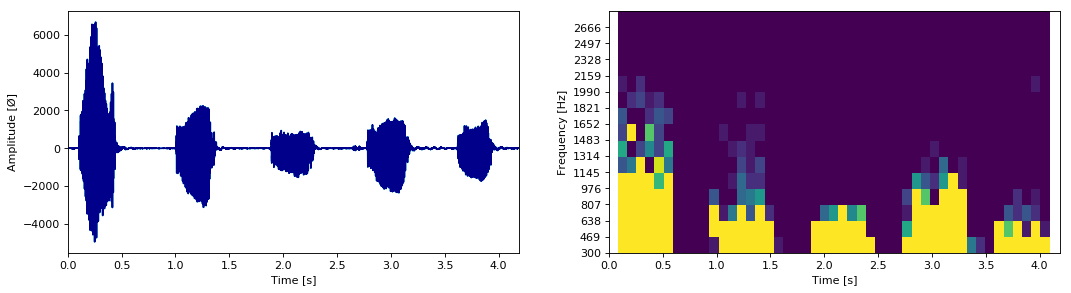

In [19]:
ax, rspectrum, rfreqs, rtime = gen_data(filtered, fs, time_res, amp_res, psd_max)
plot_data(ax, y, t, rspectrum, rfreqs, rtime, step=round((fmax-fmin)/nb_filters))

# Etude des états

Afin de faciliter le traitement des données, il est possible de lire la valeur d'un retournée par l'état d'un filtre à un instant *t* donnée.

In [20]:
#!masquer
# Détecter la valeur des filtres stimulées par le signal d'entrée.
# - s : Temps (valeur comprise entre 0 et la durée du signal audio)
# - filter_no : Indice du filtre
# - rspectrum : Spectre généré par la fonction gen_data
# - rtime : Liste de points temporels généré par la fonction gen_data
# Elle retourne la liste des états sous forme numérique selon la résolution définie.
# - states : Liste de valeurs
def state_at(filter_no, s, rspectrum, rtime):
    # Calcul de l'indice dans la séquence
    i = 0
    while (i < len(rtime)) and (rtime[i] < s):
        i = i+1
    # Retourne l'état du filtre au temps spécifié
    return rspectrum[filter_no][i]

Par exemple, pour récupérer la valeur du filtre **10** à **t=0.01s** :

In [21]:
state_at(15, 0, rspectrum, rtime)

0.0

# Résumé

Il est possible d'exécuter toutes les fonctions ci-dessus avec la fonction **compute**.

In [22]:
#!masquer
# Exécute le code dans sa totalité.
# - file : Source du fichier à étudier
# - fmin : Fréquence minimum
# - fmax : Fréquence maximum
# - nb_filters : Nombre de filtres
# - step : Pas de génération des filtres
# - q : Facteur de qualité
# - n : Ordre du filtre
# - time_res : Résolution temporelle
# - amp_res : Résolution en amplitude
# - psd_max : Amplitude maximum
def compute(file, fmin, fmax, nb_filters, step, q, n, time_res, amp_res, psd_max):
    # Récupération du fichier audio
    fs, y = sw.read(file)
    N = len(y)
    t = np.linspace(0, N/fs, N)
    
    # Filtrage
    filters, filters_fq = gen_filters(fmin, fmax, nb_filters, q, n, fs, step)
    filtered = gen_filtered(y, fs, filters)
    
    # Traitement
    ax, rspectrum, rfreqs, rtime = gen_data(filtered, fs, time_res, amp_res, psd_max)
    plot_data(ax, y, t, rspectrum, rfreqs, rtime, step)

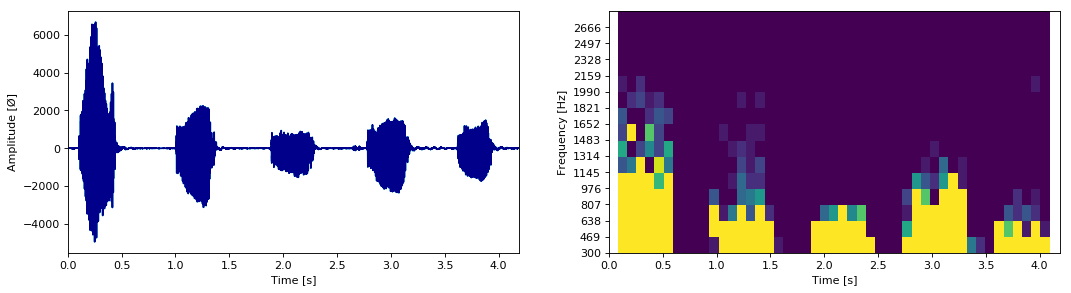

In [23]:
compute(
    file="src/test2.wav", 
    fmin=300, 
    fmax=3000, 
    nb_filters=16, 
    step=round((fmax-fmin)/nb_filters), 
    q=3, 
    n=3, 
    time_res=0.5, 
    amp_res=4, 
    psd_max=0.00000000001
)